# Validation

This notebook contains examples of some of the simulations that have been used to validate Disimpy's functionality by comparing the simulated signals to analytical solutions and signals generated by other simulators. Here, we simulate free diffusion and restricted diffusion inside cylinders and spheres.

In [1]:
# Import the required packages and modules

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from disimpy import gradients, simulations, substrates, utils
from disimpy.gradients import GAMMA

In [2]:
# Define simulation parameters

n_walkers = int(1e6)  # number of random walkers
n_t = int(1e3)  # number of time points
diffusivity = 2e-9  # in SI units (m^2/s)

## Free diffusion

In the case of free diffusion, the analytical expression for the signal is $S = S_0 \exp(-bD)$, where $S_0$ is the signal without diffusion-weighting, $b$ is the b-value, and $D$ is the diffusivity.

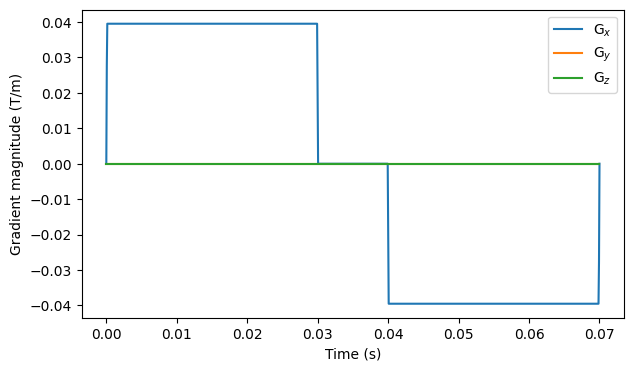

In [3]:
# Create a Stejskal-Tanner gradient array with ∆ = 40 ms and δ = 30 ms

gradient = np.zeros((1, 700, 3))
gradient[0, 1:300, 0] = 1
gradient[0, -300:-1, 0] = -1
T = 70e-3
dt = T / (gradient.shape[1] - 1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
bs = np.linspace(0, 3e9, 100)
gradient = np.concatenate([gradient for _ in bs], axis=0)
gradient = gradients.set_b(gradient, dt, bs)


# Show the waveform of the measurement with the highest b-value

fig, ax = plt.subplots(1, figsize=(7, 4))
for i in range(3):
    ax.plot(np.linspace(0, T, n_t), gradient[-1, :, i])
ax.legend(["G$_x$", "G$_y$", "G$_z$"])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Gradient magnitude (T/m)")
plt.show()

Starting simulation
Number of random walkers = 1000000
Number of steps = 1000
Step length = 9.169737405405026e-07 m
Step duration = 7.007007007007008e-05 s
Simulation finished


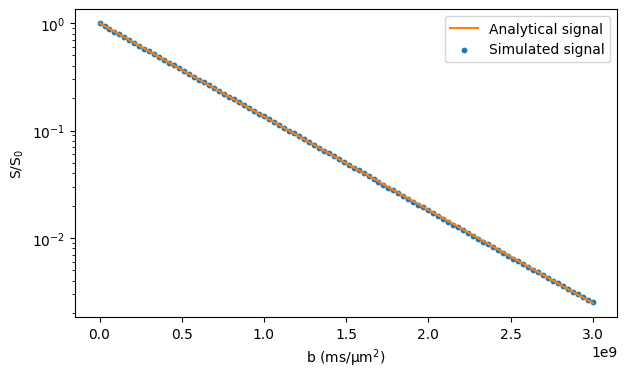

In [4]:
# Run the simulation

substrate = substrates.free()
signals = simulations.simulation(n_walkers, diffusivity, gradient, dt, substrate)


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.plot(bs, np.exp(-bs * diffusivity), color="tab:orange")
ax.scatter(bs, signals / n_walkers, s=10, marker="o")
ax.legend(["Analytical signal", "Simulated signal"])
ax.set_xlabel("b (ms/μm$^2$)")
ax.set_ylabel("S/S$_0$")
ax.set_yscale("log")
plt.show()

## Restricted diffusion and comparison to MISST

Here, diffusion inside cylinders and spheres is simulated and the signals are compared to those calculated with [MISST](http://mig.cs.ucl.ac.uk/index.php?n=Tutorial.MISST) that uses matrix operators to calculate the signal from simple geometries. The cylinder is simulated using a triangular mesh and the sphere as an analytically defined surface.

Aligning the corner of the simulated voxel with the origin
Moved the vertices by [0. 0. 0.]
Dividing the mesh into subvoxels
Finished dividing the mesh into subvoxels


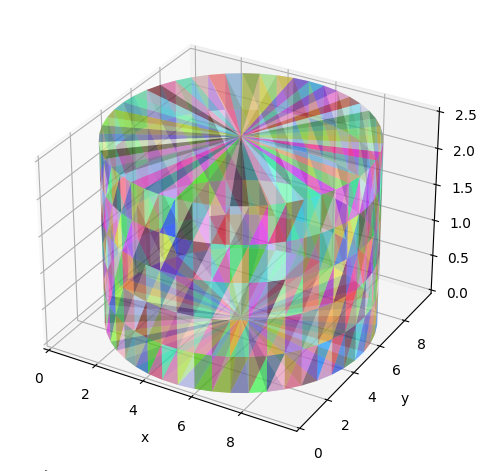

In [5]:
# Load and show the cylinder mesh used in the simulations

mesh_path = os.path.join(
    os.path.dirname(simulations.__file__), "tests", "cylinder_mesh_closed.pkl"
)
with open(mesh_path, "rb") as f:
    example_mesh = pickle.load(f)
faces = example_mesh["faces"]
vertices = example_mesh["vertices"]
cylinder_substrate = substrates.mesh(vertices, faces, periodic=True, init_pos="intra")
utils.show_mesh(cylinder_substrate)

Starting simulation
Number of random walkers = 1000000
Number of steps = 1000
Step length = 9.169737405405026e-07 m
Step duration = 7.007007007007008e-05 s
Calculating initial positions
Finished calculating initial positions
Simulation finished


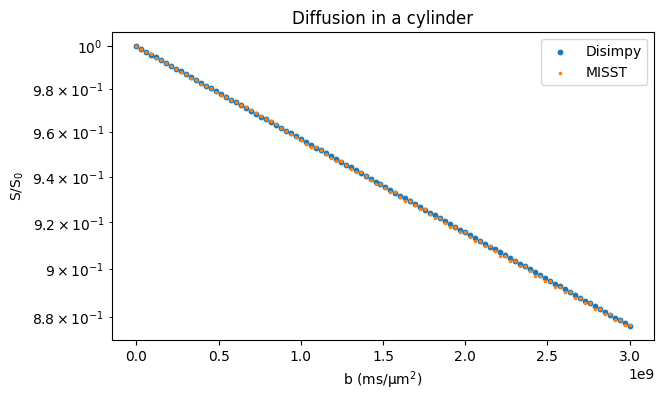

In [6]:
# Run the simulation

signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, cylinder_substrate
)


# Load MISST signals

tests_dir = os.path.join(os.path.dirname(gradients.__file__), "tests")
misst_signals = np.loadtxt(
    os.path.join(
        tests_dir, "misst_cylinder_signal_smalldelta_30ms_bigdelta_40ms_radius_5um.txt"
    )
)


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10, marker="o")
ax.scatter(bs, misst_signals, s=10, marker=".")
ax.set_xlabel("b (ms/μm$^2$)")
ax.set_ylabel("S/S$_0$")
ax.legend(["Disimpy", "MISST"])
ax.set_title("Diffusion in a cylinder")
ax.set_yscale("log")
plt.show()

Starting simulation
Number of random walkers = 1000000
Number of steps = 1000
Step length = 9.169737405405026e-07 m
Step duration = 7.007007007007008e-05 s
Simulation finished


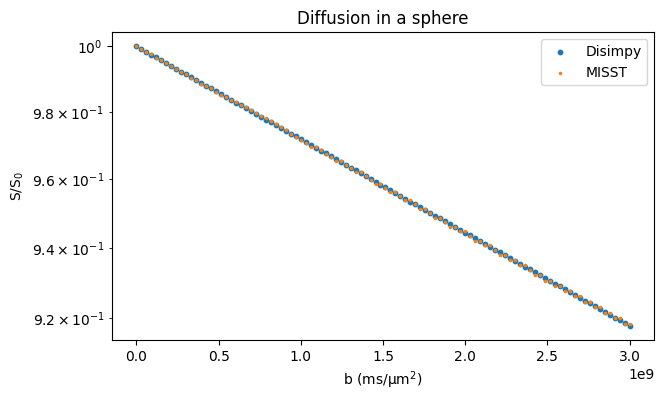

In [7]:
# Run the simulation

sphere_substrate = substrates.sphere(5e-6)
signals = simulations.simulation(n_walkers, diffusivity, gradient, dt, sphere_substrate)


# Load MISST signals

tests_dir = os.path.join(os.path.dirname(gradients.__file__), "tests")
misst_signals = np.loadtxt(
    os.path.join(
        tests_dir, "misst_sphere_signal_smalldelta_30ms_bigdelta_40ms_radius_5um.txt"
    )
)


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10, marker="o")
ax.scatter(bs, misst_signals, s=10, marker=".")
ax.set_xlabel("b (ms/μm$^2$)")
ax.set_ylabel("S/S$_0$")
ax.legend(["Disimpy", "MISST"])
ax.set_title("Diffusion in a sphere")
ax.set_yscale("log")
plt.show()

## Signal diffraction pattern

In the case of restricted diffusion in a cylinder perpendicular to the direction of the diffusion encoding gradient with short pulses and long diffusion time, the signal minimum occurs at $0.61 · 2 · \pi/r$, where $r$ is the cylinder radius. Details are provided by [Avram et al.](https://doi.org/10.1002/nbm.1277), for example.

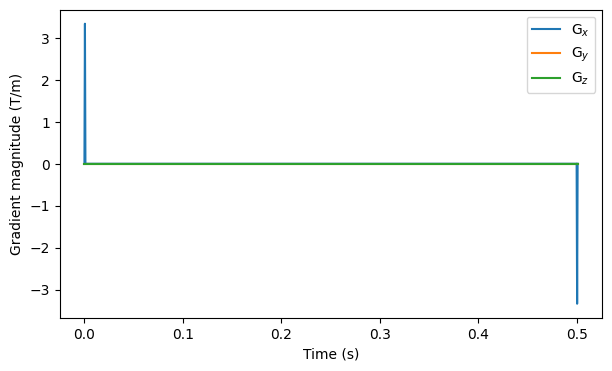

Starting simulation
Number of random walkers = 1000000
Number of steps = 1000
Step length = 2.4531648982524633e-06 m
Step duration = 0.0005015015015015015 s
Simulation finished


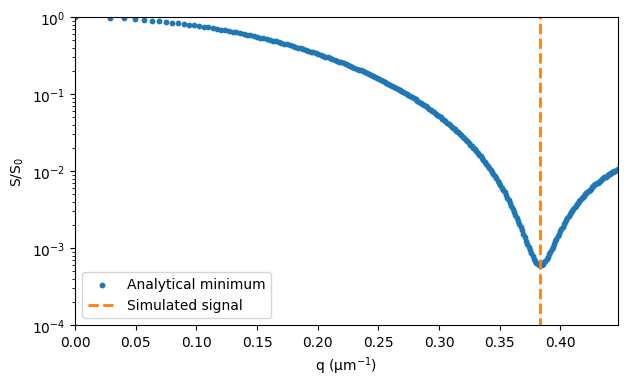

In [8]:
# Create a Stejskal-Tanner gradient array with ∆ = 0.5 s and δ = 0.1 ms

T = 501e-3
gradient = np.zeros((1, n_t, 3))
gradient[0, 1:2, 0] = 1
gradient[0, -2:-1, 0] = -1
dt = T / (gradient.shape[1] - 1)
bs = np.linspace(1, 1e11, 250)
gradient = np.concatenate([gradient for _ in bs], axis=0)
gradient = gradients.set_b(gradient, dt, bs)
q = gradients.calc_q(gradient, dt)
qs = np.max(np.linalg.norm(q, axis=2), axis=1)


# Show the waveform of the measurement with the highest b-value

fig, ax = plt.subplots(1, figsize=(7, 4))
for i in range(3):
    ax.plot(np.linspace(0, T, n_t), gradient[-1, :, i])
ax.legend(["G$_x$", "G$_y$", "G$_z$"])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Gradient magnitude (T/m)")
plt.show()


# Run the simulation

radius = 10e-6
substrate = substrates.cylinder(radius=radius, orientation=np.array([0.0, 0.0, 1.0]))
signals = simulations.simulation(n_walkers, diffusivity, gradient, dt, substrate)


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(1e-6 * qs, signals / n_walkers, s=10, marker="o")
minimum = 1e-6 * 0.61 * 2 * np.pi / radius
ax.plot([minimum, minimum], [0, 1], ls="--", lw=2, color="tab:orange")
ax.legend(["Analytical minimum", "Simulated signal"])
ax.set_xlabel("q (μm$^{-1}$)")
ax.set_ylabel("S/S$_0$")
ax.set_yscale("log")
ax.set_ylim([1e-4, 1])
ax.set_xlim([0, max(1e-6 * qs)])
plt.show()